# Example 33 - Unconformable Folded Layers

This example will show how to convert the geological map below using ``GemGIS`` to a `GemPy` model. This example is based on digitized data. The area is 1022 m wide (W-E extent) and 1172 m high (N-S extent). The model represents unconformable folded layers.

The map has been georeferenced with QGIS. The stratigraphic boundaries were digitized in QGIS. Strikes lines were digitized in QGIS as well and will be used to calculate orientations for the `GemPy` model. The contour lines were also digitized and will be interpolated with `GemGIS` to create a topography for the model. 

<img src="../images/cover_example33.png" width="800">

Map Source: Unknown

## Import GemGIS

If you have installed ``GemGIS`` via pip, you can import ``GemGIS`` like any other package. If you have downloaded the repository, append the path to the directory where the ``GemGIS`` repository is stored and then import ``GemGIS``. 

In [1]:
import warnings
warnings.filterwarnings("ignore")
import gemgis as gg

## Importing Libraries and loading Data

All remaining packages can be loaded in order to prepare the data and to construct the model. The example data is downloaded form an external server using `pooch`. It will be stored in a data folder in the same directory where this notebook is stored.  

In [2]:
import geopandas as gpd
import rasterio 

In [3]:
file_path = 'data/example32/'
gg.download_gemgis_data.download_tutorial_data(filename="example33_unconformable_folded_layers.zip", dirpath=file_path)

## Creating Digital Elevation Model from Contour Lines

The digital elevation model (DEM) will be created by interpolating contour lines digitized from the georeferenced map using the `SciPy` Radial Basis Function interpolation wrapped in `GemGIS`. The respective function used for that is `gg.vector.interpolate_raster()`. 

<img src="../images/dem_example33.png" width="800">

In [4]:
topo = gpd.read_file(file_path + 'topo33.shp')
topo['Z'] = topo['Z']*0.5
topo.head()

,id,Z,geometry
0,None,50.00,"LINESTRING (1.874 31.940, 31.950 34.114, 67.10..."
1,None,100.00,"LINESTRING (2.961 153.696, 32.675 153.696, 65...."
2,None,350.00,"LINESTRING (924.099 1.864, 942.217 14.546, 974..."
3,None,300.00,"LINESTRING (844.378 1.139, 873.367 23.606, 899..."
4,None,250.00,"LINESTRING (793.284 1.864, 816.113 29.766, 834..."


### Interpolating the contour lines

In [5]:
topo_raster = gg.vector.interpolate_raster(gdf=topo, value='Z', method='rbf', res=5)

### Plotting the raster

Text(94.3788293897884, 0.5, 'Y [m]')

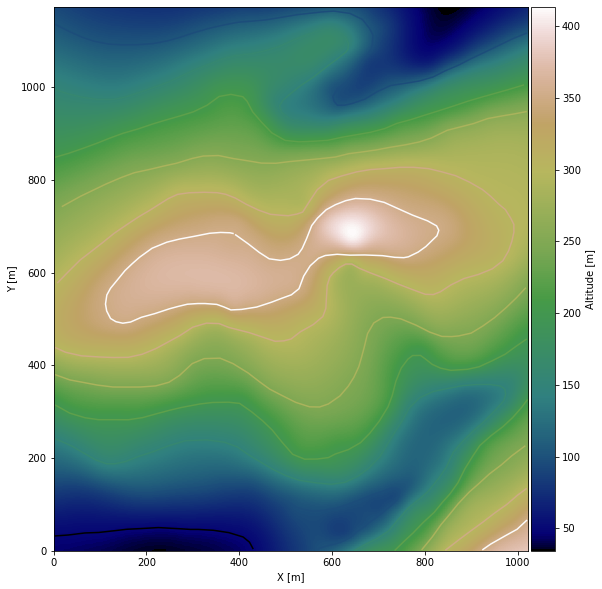

In [6]:
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable

fix, ax = plt.subplots(1, figsize=(10,10))
topo.plot(ax=ax, aspect='equal', column='Z', cmap='gist_earth')
im = ax.imshow(topo_raster, origin='lower', extent=[0,1022,0,1172], cmap='gist_earth')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('Altitude [m]')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')

### Saving the raster to disc

After the interpolation of the contour lines, the raster is saved to disc using `gg.raster.save_as_tiff()`. The function will not be executed as as raster is already provided with the example data. 

### Opening Raster

The previously computed and saved raster can now be opened using rasterio. 

In [7]:
topo_raster = rasterio.open(file_path + 'raster33.tif')

## Interface Points of stratigraphic boundaries

The interface points will be extracted from LineStrings digitized from the georeferenced map using QGIS. It is important to provide a formation name for each layer boundary. The vertical position of the interface point will be extracted from the digital elevation model using the `GemGIS` function `gg.vector.extract_xyz()`. The resulting GeoDataFrame now contains single points including the information about the respective formation. 

<img src="../images/interfaces_example33.png" width="800">

In [8]:
interfaces = gpd.read_file(file_path + 'interfaces33.shp')
interfaces.head()

,id,formation,geometry
0,None,Limestone,"LINESTRING (341.774 722.613, 381.997 720.438, ..."
1,None,Limestone,"LINESTRING (890.761 2.226, 914.315 24.330, 945..."
2,None,Claystone,"LINESTRING (765.744 0.777, 796.546 20.707, 833..."
3,None,Claystone,"LINESTRING (2.236 722.975, 34.487 765.010, 62...."


### Extracting XY coordinates from Digital Elevation Model

In [9]:
interfaces_coords = gg.vector.extract_xyz(gdf=interfaces, dem=topo_raster)
interfaces_coords = interfaces_coords.sort_values(by='formation', ascending=False)
interfaces_coords.head()

,formation,geometry,X,Y,Z
0,Limestone,POINT (341.774 722.613),341.77,722.61,338.52
54,Limestone,POINT (287.057 496.133),287.06,496.13,312.83
62,Limestone,POINT (92.828 466.781),92.83,466.78,329.27
61,Limestone,POINT (110.946 459.896),110.95,459.90,328.27
60,Limestone,POINT (132.688 453.011),132.69,453.01,325.96


### Plotting the Interface Points

(0.0, 1172.0)

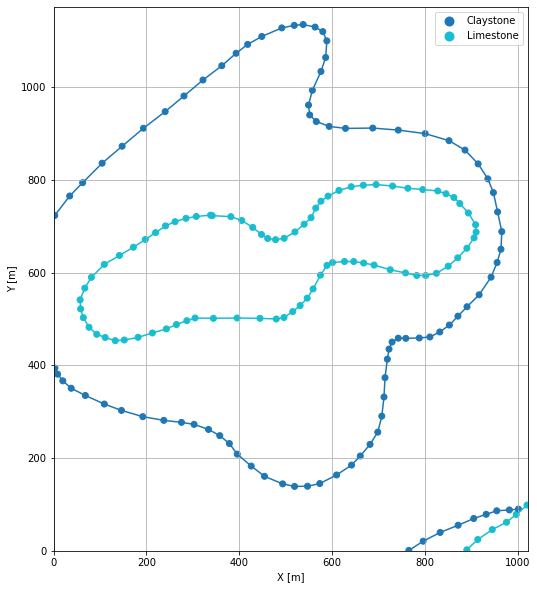

In [10]:
fig, ax = plt.subplots(1, figsize=(10,10))

interfaces.plot(ax=ax, column='formation', legend=True, aspect='equal')
interfaces_coords.plot(ax=ax, column='formation', legend=True, aspect='equal')
plt.grid()
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.xlim(0,1022)
plt.ylim(0,1172)

## Orientations from Strike Lines

Strike lines connect outcropping stratigraphic boundaries (interfaces) of the same altitude. In other words: the intersections between topographic contours and stratigraphic boundaries at the surface. The height difference and the horizontal difference between two digitized lines is used to calculate the dip and azimuth and hence an orientation that is necessary for `GemPy`. In order to calculate the orientations, each set of strikes lines/LineStrings for one formation must be given an id number next to the altitude of the strike line. The id field is already predefined in QGIS. The strike line with the lowest altitude gets the id number `1`, the strike line with the highest altitude the the number according to the number of digitized strike lines. It is currently recommended to use one set of strike lines for each structural element of one formation as illustrated. 

<img src="../images/orientations_example33.png" width="800">

In [11]:
strikes = gpd.read_file(file_path + 'strikes33.shp')
strikes['Z'] = strikes['Z']*0.5
strikes

,id,formation,Z,geometry
0,2,Limestone2,350.00,"LINESTRING (208.061 655.212, 205.887 509.540)"
1,1,Limestone2,350.00,"LINESTRING (750.887 734.208, 750.887 632.021)"
2,4,Claystone1,300.00,"LINESTRING (953.088 757.400, 950.914 613.178)"
3,3,Claystone1,250.00,"LINESTRING (823.361 895.099, 821.911 464.607)"
4,2,Limestone1,350.00,"LINESTRING (962.510 24.693, 963.235 0.052)"
5,1,Limestone1,350.00,"LINESTRING (1009.618 51.508, 1009.618 2.226)"
6,2,Claystone1,200.00,"LINESTRING (712.476 909.594, 707.403 296.468)"
7,1,Claystone1,150.00,"LINESTRING (587.097 917.566, 576.226 147.898)"
8,1,Claystone2,150.00,"LINESTRING (387.070 1070.485, 385.621 221.096)"
9,2,Claystone2,200.00,"LINESTRING (202.988 919.016, 199.364 287.047)"


### Calculate Orientations for each formation

In [12]:
orientations_claystone1 = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='Claystone1'].sort_values(by='Z', ascending=True).reset_index())
orientations_claystone1

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,21.73,270.68,175.00,POINT (645.801 567.882),1.00,Claystone1,645.80,567.88
1,24.25,270.38,225.00,POINT (766.288 641.442),1.00,Claystone1,766.29,641.44
2,21.26,270.26,275.00,POINT (887.319 682.571),1.00,Claystone1,887.32,682.57


In [13]:
orientations_claystone2 = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='Claystone2'].sort_values(by='Z', ascending=True).reset_index())
orientations_claystone2

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,15.22,90.18,175.00,POINT (293.761 624.411),1.00,Claystone2,293.76,624.41
1,15.05,90.39,225.00,POINT (107.685 581.289),1.00,Claystone2,107.68,581.29


In [14]:
orientations_claystone3 = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='Claystone3'].sort_values(by='Z', ascending=True).reset_index())
orientations_claystone3

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,21.01,269.79,275.00,POINT (887.862 297.193),1.00,Claystone3,887.86,297.19


In [15]:
orientations_limestone1 = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='Limestone1'].sort_values(by='Z', ascending=True).reset_index())
orientations_limestone1

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,0.00,88.32,350.00,POINT (986.245 19.620),1.00,Limestone1,986.24,19.62


In [16]:
orientations_limestone2 = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='Limestone2'].sort_values(by='Z', ascending=True).reset_index())
orientations_limestone2

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,0.00,90.86,350.00,POINT (478.930 632.745),1.00,Limestone2,478.93,632.75


### Merging Orientations

In [17]:
import pandas as pd
orientations = pd.concat([orientations_claystone1, orientations_claystone2, orientations_claystone3, orientations_limestone1, orientations_limestone2]).reset_index()
orientations['formation'] = ['Claystone', 'Claystone', 'Claystone', 'Claystone', 'Claystone', 'Claystone', 'Limestone', 'Limestone']
orientations

,index,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,0,21.73,270.68,175.00,POINT (645.801 567.882),1.00,Claystone,645.80,567.88
1,1,24.25,270.38,225.00,POINT (766.288 641.442),1.00,Claystone,766.29,641.44
2,2,21.26,270.26,275.00,POINT (887.319 682.571),1.00,Claystone,887.32,682.57
3,0,15.22,90.18,175.00,POINT (293.761 624.411),1.00,Claystone,293.76,624.41
4,1,15.05,90.39,225.00,POINT (107.685 581.289),1.00,Claystone,107.68,581.29
5,0,21.01,269.79,275.00,POINT (887.862 297.193),1.00,Claystone,887.86,297.19
6,0,0.00,88.32,350.00,POINT (986.245 19.620),1.00,Limestone,986.24,19.62
7,0,0.00,90.86,350.00,POINT (478.930 632.745),1.00,Limestone,478.93,632.75


### Plotting the Orientations

(0.0, 1172.0)

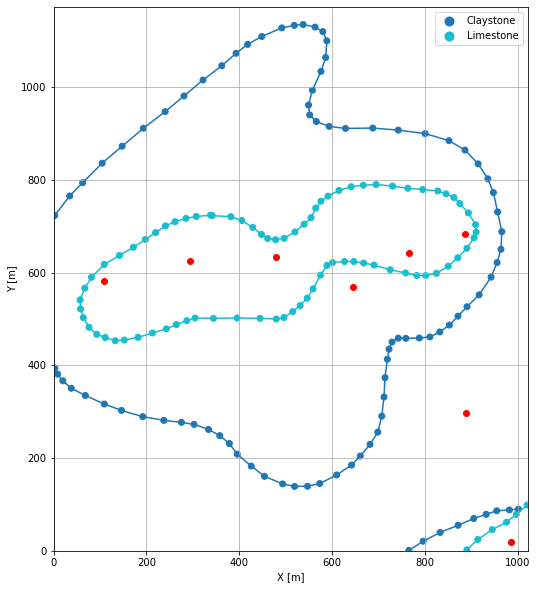

In [18]:
fig, ax = plt.subplots(1, figsize=(10,10))

interfaces.plot(ax=ax, column='formation', legend=True, aspect='equal')
interfaces_coords.plot(ax=ax, column='formation', legend=True, aspect='equal')
orientations.plot(ax=ax, color='red', aspect='equal')
plt.grid()
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.xlim(0,1022)
plt.ylim(0,1172)

## GemPy Model Construction

The structural geological model will be constructed using the `GemPy` package. 

In [19]:
import gempy as gp

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Creating new Model

In [20]:
geo_model = gp.create_model('Model33')
geo_model

Model33  2021-04-10 11:38

### Initiate Data

In [21]:
gp.init_data(geo_model, [0,1022,0,1172,0,900], [100,100,100],
             surface_points_df = interfaces_coords[interfaces_coords['Z']!=0],
             orientations_df = orientations,
             default_values=True)

Active grids: ['regular']


Model33  2021-04-10 11:38

### Model Surfaces

In [22]:
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,Limestone,Default series,1,#015482,1
1,Claystone,Default series,2,#9f0052,2


### Mapping the Stack to Surfaces

In [23]:
gp.map_stack_to_surfaces(geo_model,
                         {
                          'Strata1': ('Limestone'),
                          'Strata2': ('Claystone')
                         },
                         remove_unused_series=True)
geo_model.add_surfaces('Sandstone')

,surface,series,order_surfaces,color,id
0,Limestone,Strata1,1,#015482,1
1,Claystone,Strata2,1,#9f0052,2
2,Sandstone,Strata2,2,#ffbe00,3


### Adding additional Orientations

In [24]:
geo_model.add_orientations(X=250, Y=1000, Z=300, surface='Limestone', orientation = [0,0,1])
geo_model.add_orientations(X=750, Y=1000, Z=300, surface='Limestone', orientation = [0,0,1])
geo_model.add_orientations(X=250, Y=200, Z=300, surface='Limestone', orientation = [0,0,1])
geo_model.add_orientations(X=750, Y=200, Z=300, surface='Limestone', orientation = [0,0,1])
geo_model.add_orientations(X=500, Y=50, Z=100, surface='Claystone', orientation = [0,0,1])
geo_model.add_orientations(X=500, Y=600, Z=350, surface='Claystone', orientation = [0,0,1])
geo_model.add_orientations(X=500, Y=1000, Z=150, surface='Claystone', orientation = [0,0,1])

,X,Y,Z,G_x,G_y,G_z,smooth,surface
6,986.24,19.62,350.00,0.00,0.00,1.00,0.01,Limestone
7,478.93,632.75,350.00,0.00,0.00,1.00,0.01,Limestone
8,250.00,1000.00,300.00,0.00,0.00,1.00,0.01,Limestone
9,750.00,1000.00,300.00,0.00,0.00,1.00,0.01,Limestone
10,250.00,200.00,300.00,0.00,0.00,1.00,0.01,Limestone
11,750.00,200.00,300.00,0.00,0.00,1.00,0.01,Limestone
0,645.80,567.88,175.00,-0.37,0.00,0.93,0.01,Claystone
1,766.29,641.44,225.00,-0.41,0.00,0.91,0.01,Claystone
2,887.32,682.57,275.00,-0.36,0.00,0.93,0.01,Claystone
3,293.76,624.41,175.00,0.26,-0.00,0.96,0.01,Claystone


### Showing the Number of Data Points

In [25]:
gg.utils.show_number_of_data_points(geo_model=geo_model)

,surface,series,order_surfaces,color,id,No. of Interfaces,No. of Orientations
0,Limestone,Strata1,1,#015482,1,85,6
1,Claystone,Strata2,1,#9f0052,2,90,9
2,Sandstone,Strata2,2,#ffbe00,3,0,0


### Loading Digital Elevation Model

In [26]:
geo_model.set_topography(
    source='gdal', filepath=file_path + 'raster33.tif')

Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']


Grid Object. Values: 
array([[   5.11      ,    5.86      ,    4.5       ],
       [   5.11      ,    5.86      ,   13.5       ],
       [   5.11      ,    5.86      ,   22.5       ],
       ...,
       [1019.49509804, 1159.4248927 ,   76.11084747],
       [1019.49509804, 1164.45493562,   73.8138504 ],
       [1019.49509804, 1169.48497854,   71.72492218]])

### Defining Custom Section

In [27]:
custom_section = gpd.read_file(file_path + 'customsection33.shp')
custom_section_dict = gg.utils.to_section_dict(custom_section, section_column='name')
geo_model.set_section_grid(custom_section_dict)

Active grids: ['regular' 'topography' 'sections']


,start,stop,resolution,dist
Section1,"[3.685512376796794, 1168.3245583161138]","[1018.3144876418132, 2.95070672600923]","[100, 80]",1545.18


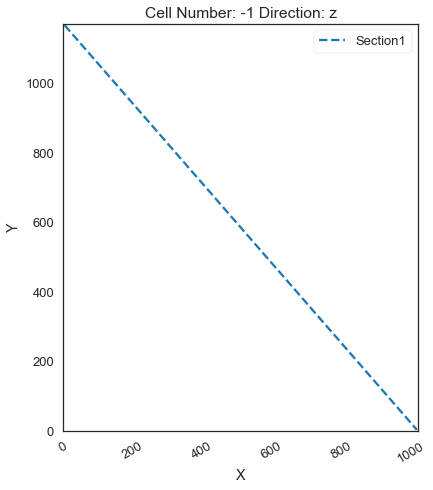

In [28]:
gp.plot.plot_section_traces(geo_model)

### Plotting Input Data

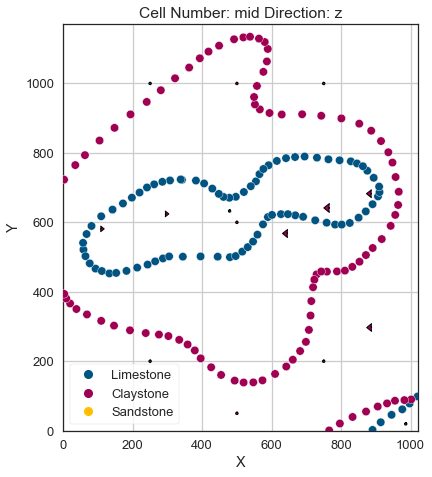

In [29]:
gp.plot_2d(geo_model, direction='z', show_lith=False, show_boundaries=False)
plt.grid()

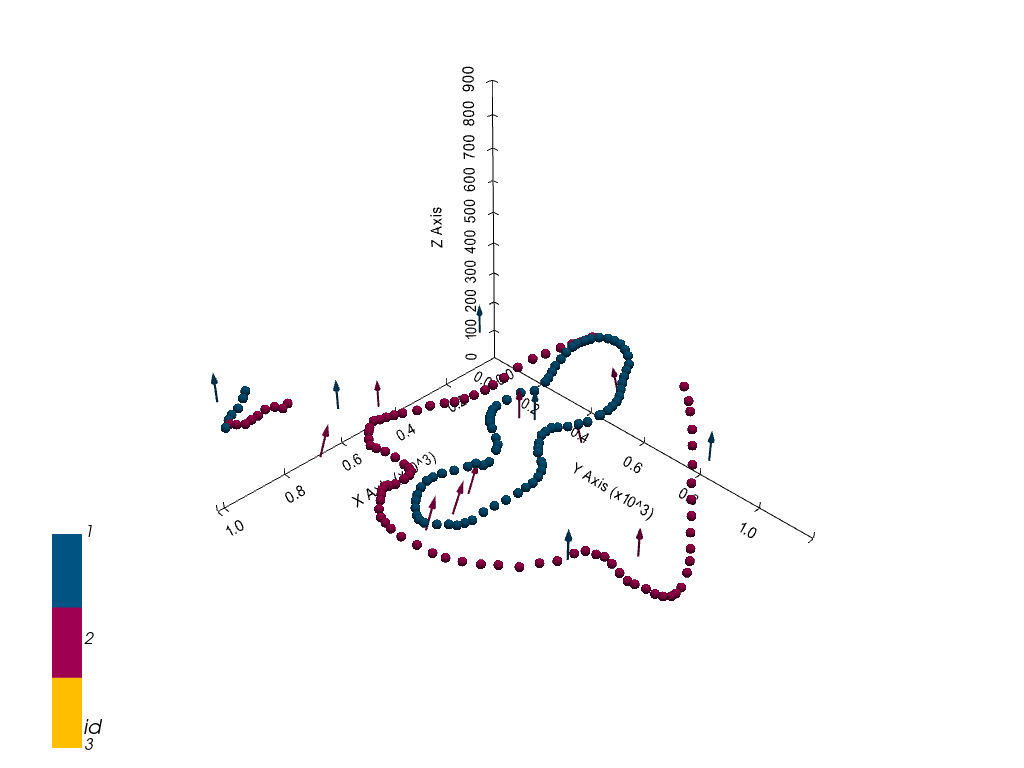

In [30]:
gp.plot_3d(geo_model, image=False, plotter_type='basic', notebook=True)

### Setting the Interpolator

In [31]:
gp.set_interpolator(geo_model,
                    compile_theano=True,
                    theano_optimizer='fast_compile',
                    verbose=[],
                    update_kriging = False
                    )

Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                   values
range            1796.68
$C_o$           76858.76
drift equations   [3, 3]


### Computing Model

In [32]:
sol = gp.compute_model(geo_model, compute_mesh=True)

### Plotting Cross Sections

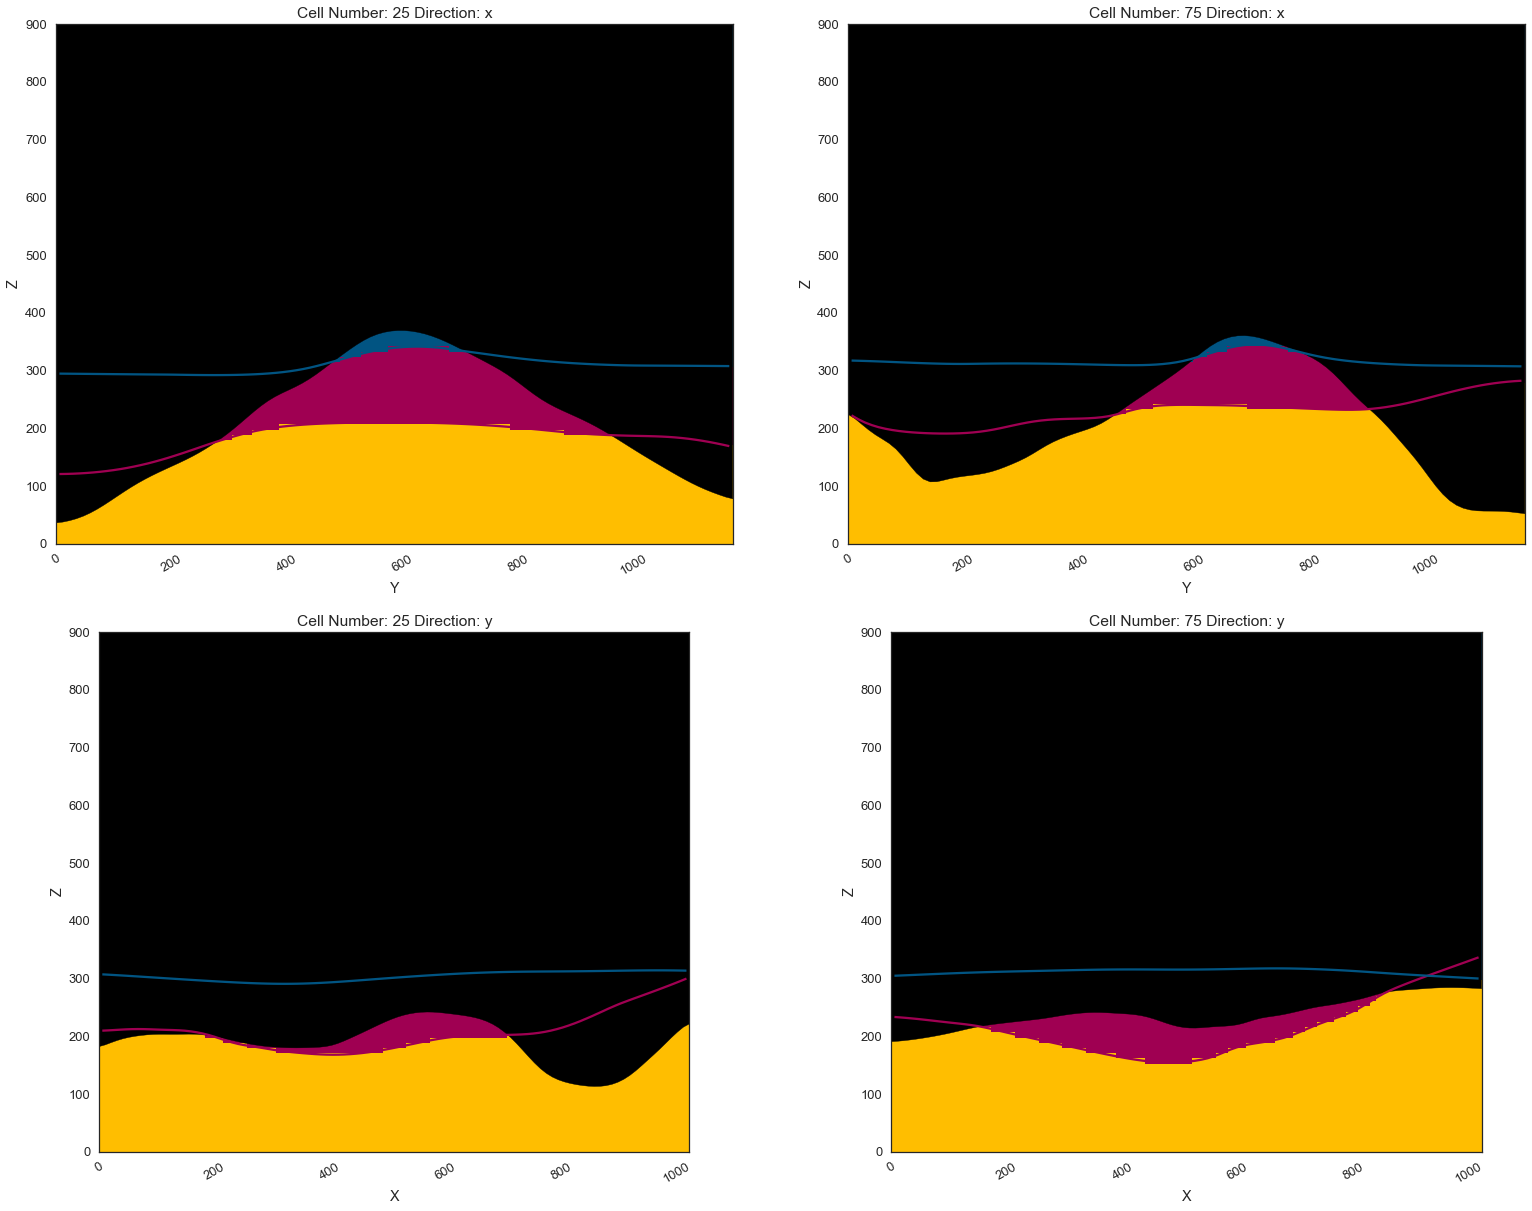

In [33]:
gp.plot_2d(geo_model, direction=['x', 'x', 'y', 'y'], cell_number=[25,75,25,75], show_topography=True, show_data=False)

### Plotting 3D Model

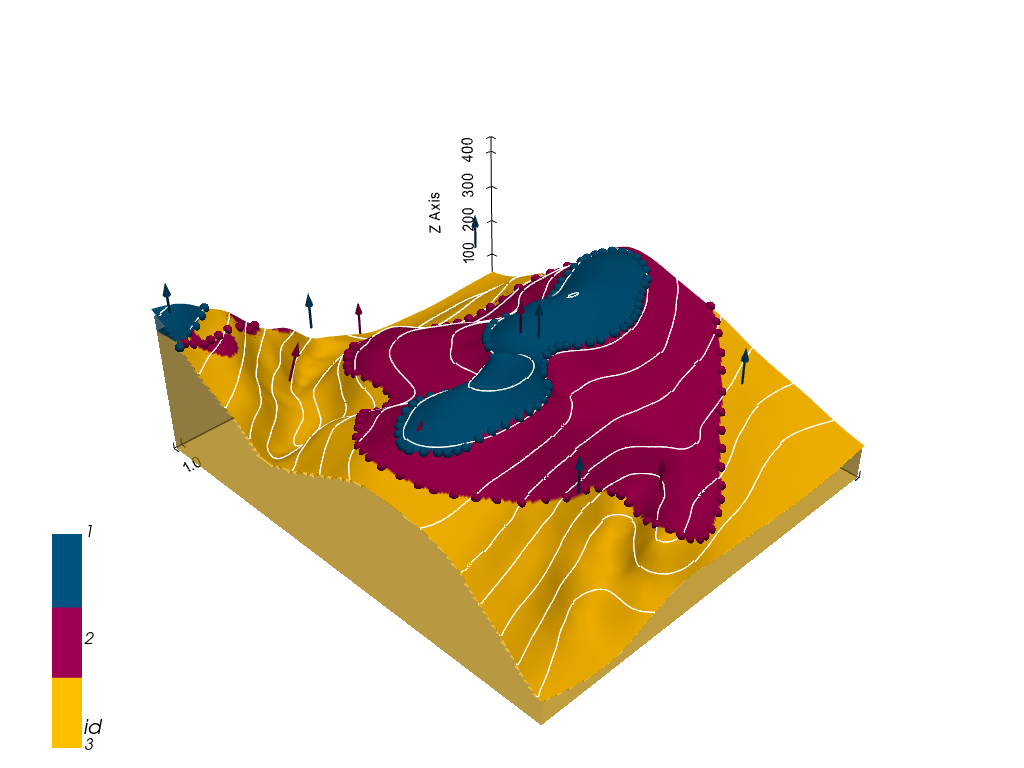

In [34]:
gpv = gp.plot_3d(geo_model, image=False, show_topography=True,
                 plotter_type='basic', notebook=True, show_lith=True)